## todo


- add cm
- add xgboost to custom.json
- add cleaning
- add t-SNE
- add other datasets
- - iris, moon, blobs


## parameters

In [18]:
CLUSTER_ALGO = 'KMedoids'
N_CLUSTERS = 21
CLUSTERS_STD = 0.25
N_P_CLUSTERS =  [3,30, 100, 300, 3000]

## imports

In [2]:
%matplotlib inline

import matplotlib

import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons





In [3]:
%load_ext autoreload
%autoreload 2
packages = !conda list
packages

['# packages in environment at /opt/conda:',
 '#',
 '# Name                    Version                   Build  Channel',
 '_libgcc_mutex             0.1                 conda_forge    conda-forge',
 '_openmp_mutex             4.5                       0_gnu    conda-forge',
 'alembic                   1.4.2              pyh9f0ad1d_0    conda-forge',
 'astroid                   2.4.1                    pypi_0    pypi',
 'astunparse                1.6.3                    pypi_0    pypi',
 'async_generator           1.10                       py_0    conda-forge',
 'attrs                     19.3.0                     py_0    conda-forge',
 'backcall                  0.1.0                      py_0    conda-forge',
 'bleach                    3.1.4              pyh9f0ad1d_0    conda-forge',
 'blinker                   1.4                        py_1    conda-forge',
 'brotlipy                  0.7.0           py37h8f50634_1000    conda-forge',
 'ca-certificates           2020.4.5.1     

In [4]:
!pwd


/docker/photon_experiments


## Output registry

In [5]:
from __future__ import print_function
import sys, os

old__file__ = !pwd
__file__ = !cd ../photon ;pwd
#__file__ = !pwd
__file__ = __file__[0]
__file__
sys.path.append(__file__)
print(sys.path)
os.chdir(old__file__[0])
!pwd
old__file__[0]

['/docker/photon_experiments', '/opt/conda/lib/python37.zip', '/opt/conda/lib/python3.7', '/opt/conda/lib/python3.7/lib-dynload', '', '/opt/conda/lib/python3.7/site-packages', '/opt/conda/lib/python3.7/site-packages/IPython/extensions', '/home/jovyan/.ipython', '/docker/photon']
/docker/photon_experiments


'/docker/photon_experiments'

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


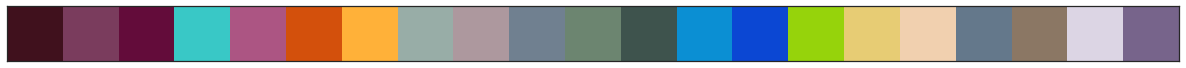

In [6]:

import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#set font size of labels on matplotlib plots
plt.rc('font', size=16)

#set style of plots
sns.set_style('white')

#define a custom palette
customPalette = ['#40111D', '#7A3C5D', '#630C3A'
                 ,'#39C8C6', '#AC5583', '#D3500C'
                 ,'#FFB139', '#98ADA7', '#AD989E'
                 ,'#708090','#6C8570','#3E534D'
                 ,'#0B8FD3','#0B47D3','#96D30B'                 
                 ,'#E7CC74','#F1D0AF','#64788B'                 
                 ,'#8B7764','#DCD5E4','#77648B',]
sns.set_palette(customPalette)
sns.palplot(customPalette)


from clusim.clustering import Clustering, remap2match
import clusim.sim as sim

from photonai.base import Hyperpipe, PipelineElement, Preprocessing, OutputSettings
from photonai.optimization import FloatRange, Categorical, IntegerRange
from photonai.base.photon_elements import PhotonRegistry
from photonai.visual.graphics import plot_cm
#from photonai.base.registry.registry import PhotonRegistry

## functions

In [7]:
def results_to_df(results):
    ll = []
    for obj in results:
        ll.append([obj.operation,
        obj.value,
        obj.metric_name])
    _results=pd.DataFrame(ll).pivot(index=2, columns=0, values=1)
    _results.columns=['Mean','STD']
    
    return(_results)

In [8]:
def cluster_plot(my_pipe, data_X, customPalette):
    y_pred= my_pipe.predict(data_X)
    data = pd.DataFrame(data_X[:, 0],columns=['x'])
    data['y'] = data_X[:, 1]
    data['labels'] = y_pred
    facet = sns.lmplot(data=data, x='x', y='y', hue='labels', 
                       aspect= 1.0, height=7,
               fit_reg=False, legend=True, legend_out=True)

    for i, label in enumerate( np.sort(data['labels'].unique())):
        plt.annotate(label, 
                     data.loc[data['labels']==label,['x','y']].mean(),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=10, weight='bold',
                     color='white',
                     backgroundcolor=customPalette[i]) 

    plt.show()
    return y_pred

In [9]:
import sklearn.datasets as skd
NC = 21
def yield_parameters(n_p_clusters):
    n_cluster = N_CLUSTERS
    cluster_std = CLUSTERS_STD

    for n_p_cluster in n_p_clusters:
        n_cluster_std = [cluster_std*k**0.5+0.2 for k in range(n_cluster)]
        print("n_cluster_std:", n_cluster_std)
        n_samples = [n_p_cluster for k in range(n_cluster)]
        data_X, data_y = make_blobs(n_samples=n_samples,
                                   cluster_std=n_cluster_std, random_state=0)
        yield [data_X, data_y]

In [10]:
__file__ = "exp1.log"
base_folder = os.path.dirname(os.path.abspath(''))
custom_elements_folder = os.path.join(base_folder, 'custom_elements')
custom_elements_folder

'/docker/custom_elements'

In [11]:
registry = PhotonRegistry(custom_elements_folder=custom_elements_folder)
registry.activate()
registry.PHOTON_REGISTRIES,PhotonRegistry.PHOTON_REGISTRIES

(['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'],
 ['PhotonCore', 'PhotonCluster', 'PhotonNeuro', 'CustomElements'])

In [12]:
registry.activate()
registry.list_available_elements()
# take off last name


PhotonCore
ARDRegression                       sklearn.linear_model.ARDRegression                                          Estimator
AdaBoostClassifier                  sklearn.ensemble.AdaBoostClassifier                                         Estimator
AdaBoostRegressor                   sklearn.ensemble.AdaBoostRegressor                                          Estimator
BaggingClassifier                   sklearn.ensemble.BaggingClassifier                                          Estimator
BaggingRegressor                    sklearn.ensemble.BaggingRegressor                                           Estimator
BayesianGaussianMixture             sklearn.mixture.BayesianGaussianMixture                                     Estimator
BayesianRidge                       sklearn.linear_model.BayesianRidge                                          Estimator
BernoulliNB                         sklearn.naive_bayes.BernoulliNB                                             Estimator
BernoulliRBM

## KMedoids blobs

In [13]:
registry.info(CLUSTER_ALGO)

----------------------------------
Name: KMedoids
Namespace: sklearn_extra.cluster
----------------------------------
Possible Hyperparameters as derived from constructor:
n_clusters                          n_clusters=8                                                               
metric                              metric='euclidean'                                                         
init                                init='heuristic'                                                           
max_iter                            max_iter=300                                                               
random_state                        random_state=None                                                          
----------------------------------


('KMedoids',
 'sklearn_extra.cluster',
 {'n_clusters': 'n_clusters',
  'metric': 'metric',
  'init': 'init',
  'max_iter': 'max_iter',
  'random_state': 'random_state'})

In [20]:
def hyper_cluster(cluster_name):
    
    n_p_clusters = N_P_CLUSTERS

    for data_X, data_y  in yield_parameters(n_p_clusters):
        print('n_points:', len(data_y))
        """
        Example script for KMedoids hopt
        """
        X = data_X.copy(); y =  data_y.copy()
        # DESIGN YOUR PIPELINE
        settings = OutputSettings(project_folder='./tmp/')

        my_pipe = Hyperpipe('batching',
                            optimizer='sk_opt',
        #                    optimizer_params={'n_configurations': 25},
                            metrics=['ARI', 'MI', 'HCV', 'FM'],
                            best_config_metric='ARI',
                            outer_cv=KFold(n_splits=5),
                            inner_cv=KFold(n_splits=10),
                            verbosity=0,
                            output_settings=settings)


        my_pipe += PipelineElement(cluster_name
                                   , hyperparameters={
                                       'n_clusters': IntegerRange(int(N_CLUSTERS/2)
                                                                  , N_CLUSTERS),
                                   },random_state=777)

        # NOW TRAIN YOUR PIPELINE
        my_pipe.fit(X, y)

        debug = True

    #------------------------------plot
        y_pred=cluster_plot(my_pipe, X, customPalette)
    #--------------------------------- best
        print(pd.DataFrame(my_pipe.best_config.items()
                           ,columns=['n_clusters', 'k']))
    #------------------------------
        print('train','\n'
              ,results_to_df(my_pipe.results.metrics_train))
        print('test','\n'
              ,results_to_df(my_pipe.results.metrics_test))
    #------------------------------   
        # turn the ground-truth labels into a clusim Clustering
        true_clustering = Clustering().from_membership_list(y) 
        kmeans_clustering = Clustering().from_membership_list(y_pred) # lets see how similar the predicted k-means clustering is to the true clustering
    #------------------------------
        # using all available similar measures!
        row_format2 ="{:>25}" * (2)
        for simfunc in sim.available_similarity_measures:
            print(row_format2.format(simfunc, eval('sim.' + simfunc+'(true_clustering, kmeans_clustering)')))
    #------------------------------# The element-centric similarity is particularly useful for understanding
    # how a clustering method performed

    # Let's start with the single similarity value:
        elsim = sim.element_sim(true_clustering, kmeans_clustering)
        print("Element-centric similarity: {}".format(elsim))

n_cluster_std: [0.2, 0.45, 0.5535533905932738, 0.6330127018922194, 0.7, 0.7590169943749474, 0.8123724356957944, 0.8614378277661476, 0.9071067811865476, 0.95, 0.990569415042095, 1.02915619758885, 1.0660254037844386, 1.1013878188659973, 1.1354143466934854, 1.1682458365518542, 1.2, 1.230776406404415, 1.2606601717798211, 1.2897247358851684, 1.3180339887498949]
n_points: 63
***************************************************************************************************************
PHOTON ANALYSIS: batching
***************************************************************************************************************

********************************************************
Outer Cross validation Fold 1
********************************************************
---------------------------------------------------------------------------------------------------------------
BEST_CONFIG 
------------------------------------------------------------------------------------------------------------

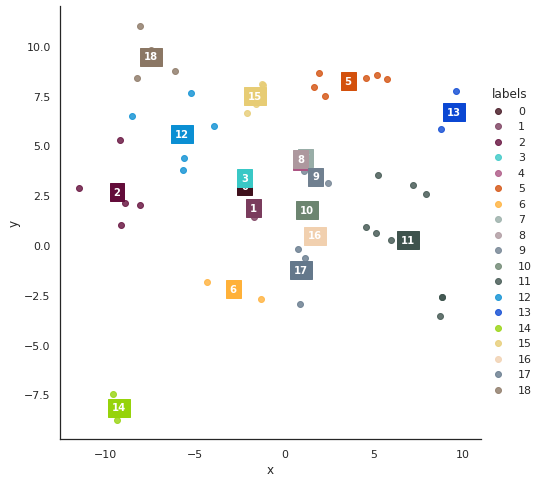

             n_clusters   k
0  KMedoids__n_clusters  19
train 
          Mean       STD
2                      
ARI  0.403172  0.063372
FM   0.461726  0.048644
HCV  0.792409  0.025390
MI   0.557270  0.032892
test 
          Mean       STD
2                      
ARI  0.208670  0.275368
FM   0.264548  0.283359
HCV  0.816727  0.072390
MI   0.232486  0.256308
            jaccard_index       0.3409090909090909
               rand_index       0.9554531490015361
            adjrand_index       0.4871648602395893
    fowlkes_mallows_index       0.5309942440535915
                 fmeasure       0.5084745762711864
             purity_index       0.6984126984126984
     classification_error       0.3015873015873016
        czekanowski_index       0.5084745762711864
               dice_index       0.5084745762711864
           sorensen_index       0.5084745762711864
    rogers_tanimoto_index       0.9147058823529411
          southwood_index       0.5172413793103449
      pearson_correlation   3

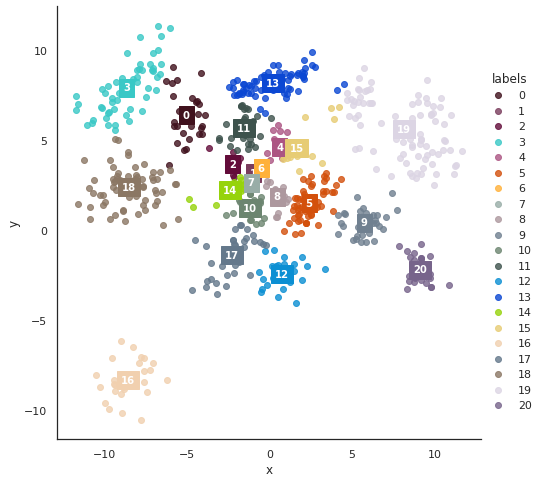

             n_clusters   k
0  KMedoids__n_clusters  21
train 
          Mean       STD
2                      
ARI  0.585271  0.016736
FM   0.619971  0.014126
HCV  0.766894  0.011487
MI   0.769926  0.006914
test 
          Mean       STD
2                      
ARI  0.563604  0.028303
FM   0.598579  0.026570
HCV  0.790712  0.013079
MI   0.716298  0.019333
            jaccard_index       0.4072782874617737
               rand_index       0.9510889040300805
            adjrand_index       0.5540201327644214
    fowlkes_mallows_index        0.591498835512518
                 fmeasure       0.5788169846581772
             purity_index       0.6317460317460317
     classification_error       0.3682539682539683
        czekanowski_index       0.5788169846581772
               dice_index       0.5788169846581772
           sorensen_index       0.5788169846581772
    rogers_tanimoto_index       0.9067392915227162
          southwood_index       0.6871323908781344
      pearson_correlation   2

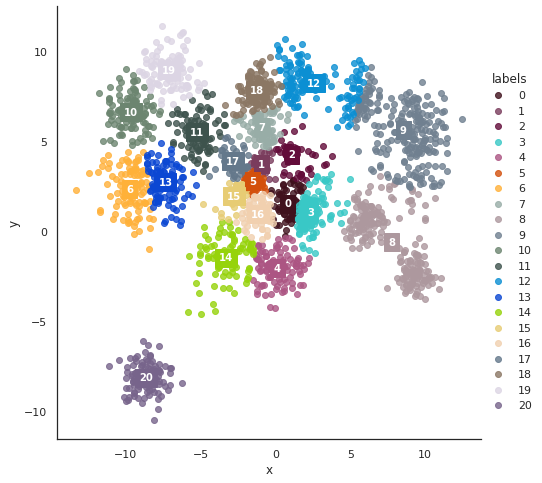

             n_clusters   k
0  KMedoids__n_clusters  21
train 
          Mean       STD
2                      
ARI  0.604074  0.024216
FM   0.632431  0.020004
HCV  0.768687  0.016803
MI   0.784221  0.012713
test 
          Mean       STD
2                      
ARI  0.591933  0.038100
FM   0.620752  0.034663
HCV  0.775296  0.018163
MI   0.760677  0.018240
            jaccard_index      0.45194071465257907
               rand_index       0.9593302933369632
            adjrand_index       0.6013923357478423
    fowlkes_mallows_index       0.6274141483814284
                 fmeasure       0.6225332895368522
             purity_index       0.7014285714285714
     classification_error       0.2985714285714286
        czekanowski_index       0.6225332895368522
               dice_index       0.6225332895368522
           sorensen_index       0.6225332895368522
    rogers_tanimoto_index       0.9218393570935269
          southwood_index       0.8246201218287703
      pearson_correlation    

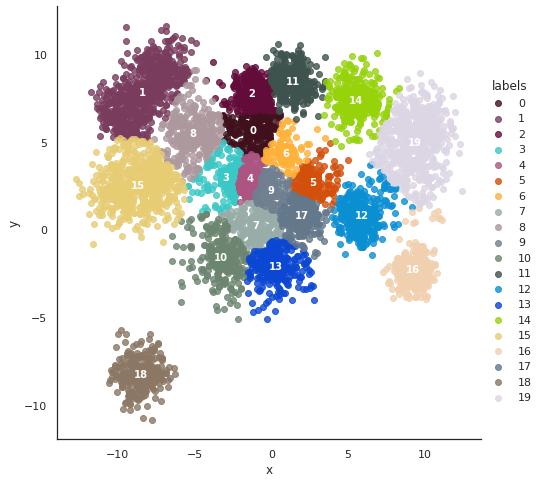

             n_clusters   k
0  KMedoids__n_clusters  20
train 
          Mean       STD
2                      
ARI  0.671900  0.010280
FM   0.692425  0.010093
HCV  0.799166  0.004926
MI   0.812953  0.004936
test 
          Mean       STD
2                      
ARI  0.675853  0.019161
FM   0.696150  0.016670
HCV  0.807919  0.011868
MI   0.813769  0.007391
            jaccard_index       0.5326487788524814
               rand_index       0.9677509909610243
            adjrand_index       0.6782329656578014
    fowlkes_mallows_index       0.6987380217396618
                 fmeasure       0.6950695895915359
             purity_index        0.746984126984127
     classification_error        0.253015873015873
        czekanowski_index       0.6950695895915359
               dice_index       0.6950695895915359
           sorensen_index       0.6950695895915359
    rogers_tanimoto_index       0.9375169968552461
          southwood_index       1.1397183846971306
      pearson_correlation    

In [ ]:
hyper_cluster(CLUSTER_ALGO)